# ADVANCED RETRIVAL AUGMENTED GENERATION FOR DATA MINING TEXT BOOK BASE CHATBOT GENERATION

## Import Libraries

In [1]:
import pandas as pf
import numpy as np
import nltk
import re
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch
from sentence_transformers import SentenceTransformer
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
from transformers import pipeline
from transformers import AutoModelForSeq2SeqLM
from transformers import AutoTokenizer
import fitz
import unicodedata
from collections import Counter

c:\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\WIN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Content Based Chunking with Metadata Connector
Each chunk includes hierarchy labels, type, rich metadata, and explicit connectors. This makes graph construction and context assembly for RAG simple and robust.

My implemented approach—content-based chunking with metadata connectors—produces the most reliable, context-rich retrieval pipeline for complex technical books. It is strongly recommended and supports all advanced RAG, knowledge graph, and multi-modal answer generation use cases.
-- Fahim Asholei ekta maal

In [2]:
import fitz
import re
import unicodedata
from collections import Counter
from nltk.tokenize import sent_tokenize

CHAPTER_RE = re.compile(r'^\s*(Chapter|CHAPTER|CH)\s*\d+', re.IGNORECASE)
SECTION_RE = re.compile(r'^\s*\d+(\.\d+)+\s+[A-Z][\w ]+', re.IGNORECASE)
INDEX_RE = re.compile(r'^\s*(Index|Contents|Table of Contents)', re.IGNORECASE)
EXAMPLE_RE = re.compile(r'^\s*(Example|EXAMPLE|EX)\s*\d+', re.IGNORECASE)
LATEX_MATH_RE = re.compile(r'(\$\$.*?\$\$|\$.*?\$|\\\[.*?\\\]|\\\(.+?\\\))', re.DOTALL)

def clean_text(text):
    text = unicodedata.normalize("NFKC", text)
    text = re.sub(r'-\s*\n\s*', '', text)
    text = re.sub(r'(?<!\n)\n(?!\n)', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def extract_pdf_with_connectors(pdf_path, min_block_len=20, heading_scale=1.25):
    doc = fitz.open(pdf_path)
    content_chunks = []
    hierarchy = {
        'chapter': None, 'section': None, 'subsection': None, 'subsubsection': None, 'example': None, 'index': None
    }

    chunk_idx = 0
    prev_chunk_id = None

    for pno in range(doc.page_count):
        page = doc.load_page(pno)
        d = page.get_text("dict")
        sizes = []
        for b in d["blocks"]:
            if b.get("type", 0) == 0:
                for line in b.get("lines", []):
                    for span in line.get("spans", []):
                        sizes.append(span.get("size", 0))
        median_size = (sorted(sizes)[len(sizes)//2] if sizes else 0)

        for b in d["blocks"]:
            if b.get("type", 0) != 0:
                continue
            text = " ".join(span.get("text","") for line in b.get("lines", []) for span in line.get("spans", []))
            text = clean_text(text)
            if not text or len(text) < min_block_len:
                continue
            max_span = max(span.get("size", 0) for line in b.get("lines", []) for span in line.get("spans", [])) if b.get("lines") else 0
            # Update hierarchy
            if CHAPTER_RE.match(text): hierarchy['chapter'] = text
            elif SECTION_RE.match(text): hierarchy['section'] = text
            elif INDEX_RE.match(text): hierarchy['index'] = text
            elif EXAMPLE_RE.match(text): hierarchy['example'] = text

            is_heading = (median_size > 0 and max_span >= median_size * heading_scale) or bool(CHAPTER_RE.match(text) or SECTION_RE.match(text))
            is_index = bool(INDEX_RE.match(text))
            is_example = bool(EXAMPLE_RE.match(text))
            latex_equations = LATEX_MATH_RE.findall(text)

            chunk = {
                'chunk_id': chunk_idx,
                'type': 'text',
                'content': text,
                'page': pno+1,
                'is_heading': is_heading,
                'hierarchy': hierarchy.copy(),
                'latex_equations': latex_equations,
                'metadata': {
                    'font_size': max_span,
                    'median_size': median_size,
                    'is_index': is_index,
                    'is_example': is_example
                },
                'prev_chunk_id': prev_chunk_id,
                # next_chunk_id will be set after the loop
            }
            content_chunks.append(chunk)
            prev_chunk_id = chunk_idx
            chunk_idx += 1

        # Images
        for img in page.get_images(full=True):
            xref = img[0]
            bbox = None
            if hasattr(page, "get_image_bbox"):
                try: bbox = page.get_image_bbox(xref)
                except Exception: bbox = None
            caption = None
            for b in d["blocks"]:
                if b.get("type",0) != 0: continue
                for line in b.get("lines", []):
                    for span in line.get("spans", []):
                        if span.get("text") and "figure" in span.get("text").lower():
                            caption = clean_text(span.get("text"))
            chunk = {
                'chunk_id': chunk_idx,
                'type': 'image',
                'page': pno+1,
                'xref': xref,
                'bbox': bbox,
                'caption': caption,
                'hierarchy': hierarchy.copy(),
                'prev_chunk_id': prev_chunk_id,
            }
            content_chunks.append(chunk)
            prev_chunk_id = chunk_idx
            chunk_idx +=1

        # Tables
        for b in d["blocks"]:
            if b.get("type",0) != 0: continue
            if " | " in b.get("lines", [])[0]['spans'][0]['text'] if b.get("lines") and b.get("lines", [])[0]['spans'] else False:
                table_content = clean_text(" ".join(span.get("text","") for line in b.get("lines", []) for span in line.get("spans", [])))
                chunk = {
                    'chunk_id': chunk_idx,
                    'type': 'table',
                    'content': table_content,
                    'page': pno+1,
                    'hierarchy': hierarchy.copy(),
                    'prev_chunk_id': prev_chunk_id,
                }
                content_chunks.append(chunk)
                prev_chunk_id = chunk_idx
                chunk_idx += 1

    # Assign next_chunk_id for all chunks
    for i in range(len(content_chunks) - 1):
        content_chunks[i]['next_chunk_id'] = content_chunks[i+1]['chunk_id']
    content_chunks[-1]['next_chunk_id'] = None

    return content_chunks

# Usage:
# chunks = extract_pdf_with_connectors('DS-book-u5.pdf')

# Each chunk dictionary contains chunk_id, prev_chunk_id, next_chunk_id, hierarchy (chapter, section, et.), type (text/image/table), and all metadata to support graph, context, and semantic retrieval.


In [3]:
chunks = extract_pdf_with_connectors('DS-book u5.pdf')

In [4]:
# get one specific chunk
specific_chunk = chunks[120]
print(specific_chunk)
# length of the specific shunk text
print(len(specific_chunk['content']))   

{'chunk_id': 120, 'type': 'text', 'content': 'Example 1.1 Data mining turns a large collection of data into knowledge. A search engine (e.g., Google) receives hundreds of millions of queries every day. Each query can be viewed as a transaction where the user describes her or his information need. What novel and useful knowledge can a search engine learn from such a huge collection of queries col- lected from users over time? Interestingly, some patterns found in user search queries can disclose invaluable knowledge that cannot be obtained by reading individual data items alone. For example, Google’s Flu Trends uses specific search terms as indicators of flu activity. It found a close relationship between the number of people who search for flu-related information and the number of people who actually have flu symptoms. A pattern emerges when all of the search queries related to flu are aggregated. Using aggre- gated Google search data, Flu Trends can estimate flu activity up to two wee

## Graph Based Multi-modal  Knowladge Grounding
This cell takes the content-aware chunks (with connectors, hierarchy, and multimodal metadata) and builds a knowledge graph (KG) representing relationships between entities (concepts, images, sections, formulas, tables) from your book. The graph can be visualized, walked for context, and used for advanced retrieval.

In [5]:
import networkx as nx

# Assume 'chunks' is the output from the previous cell, a list of dicts
# Each chunk has: chunk_id, content, type, hierarchy, prev_chunk_id, next_chunk_id, latex_equations, etc.

def extract_entities_relations(chunk):
    """
    Simple entity extraction per chunk using section headings, formulas, keywords, captions.
    You can swap in advanced NLP for better entity/relation detection.
    """
    entities = []
    relations = []
    # Example: Headings as topic entities
    for key in ['chapter', 'section', 'subsection', 'example']:
        if chunk['hierarchy'].get(key):
            entities.append({'type': 'topic', 'value': chunk['hierarchy'][key], 'chunk_id': chunk['chunk_id']})

    # Example: If formula present, treat as concept entity
    for eq in chunk.get('latex_equations', []):
        entities.append({'type': 'formula', 'value': eq, 'chunk_id': chunk['chunk_id']})

    # Example: Images as entities (with caption if any)
    if chunk['type'] == 'image':
        if chunk.get('caption'):
            entities.append({'type': 'figure', 'value': chunk['caption'], 'chunk_id': chunk['chunk_id']})
        else:
            entities.append({'type': 'figure', 'value': f"Image on page {chunk['page']}", 'chunk_id': chunk['chunk_id']})

    # Example: Tables as entities (could be improved)
    if chunk['type'] == 'table':
        entities.append({'type': 'table', 'value': f"Table on page {chunk['page']}", 'chunk_id': chunk['chunk_id']})

    # Connectors as relations (semantic neighborhood)
    if chunk.get('prev_chunk_id') is not None:
        relations.append({'source': chunk['chunk_id'], 'target': chunk['prev_chunk_id'], 'type': 'prev'})
    if chunk.get('next_chunk_id') is not None:
        relations.append({'source': chunk['chunk_id'], 'target': chunk['next_chunk_id'], 'type': 'next'})

    # Hierarchical relations: section is part of chapter, etc.
    if chunk['hierarchy']['section'] and chunk['hierarchy']['chapter']:
        relations.append({'source': chunk['hierarchy']['section'], 'target': chunk['hierarchy']['chapter'], 'type': 'part_of'})
    return entities, relations

def build_knowledge_graph(chunks):
    """
    Builds a NetworkX property graph from chunk entities and relations.
    Nodes = topics, formulas, figures, tables, chunks.
    Edges = semantic/hierarchical/contextual relations.
    """
    G = nx.DiGraph()
    for chunk in chunks:
        chunk_node = f"chunk_{chunk['chunk_id']}"
        G.add_node(chunk_node, **chunk)
        entities, relations = extract_entities_relations(chunk)
        # Add entities
        for ent in entities:
            ent_node = f"{ent['type']}:{ent['value']}"
            G.add_node(ent_node, entity_type=ent['type'], value=ent['value'], chunk_id=ent['chunk_id'])
            G.add_edge(chunk_node, ent_node, type="has_entity")
        # Add relations
        for rel in relations:
            src = f"chunk_{rel['source']}" if rel['type'] in ("prev", "next") else rel['source']
            tgt = f"chunk_{rel['target']}" if rel['type'] in ("prev", "next") else rel['target']
            G.add_edge(src, tgt, type=rel['type'])
    return G

# Usage:
# G = build_knowledge_graph(chunks)

# You can now visualize G, walk it for retrieval, or export for more advanced KG/RAG integration.
# Example: Find all formulas in the chapter "Chapter 5" or get all chunks for a given figure/table.
G = build_knowledge_graph(chunks)

### Save and Analyze the Knowledge Graph

In [6]:
# Save the graph
import pickle
import networkx as nx
with open('knowledge_graph.pkl', 'wb') as f:
    pickle.dump(G, f, protocol=pickle.HIGHEST_PROTOCOL)
## Import Libraries
with open('knowledge_graph.pkl', 'rb') as f:
    G = pickle.load(f)

In [7]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


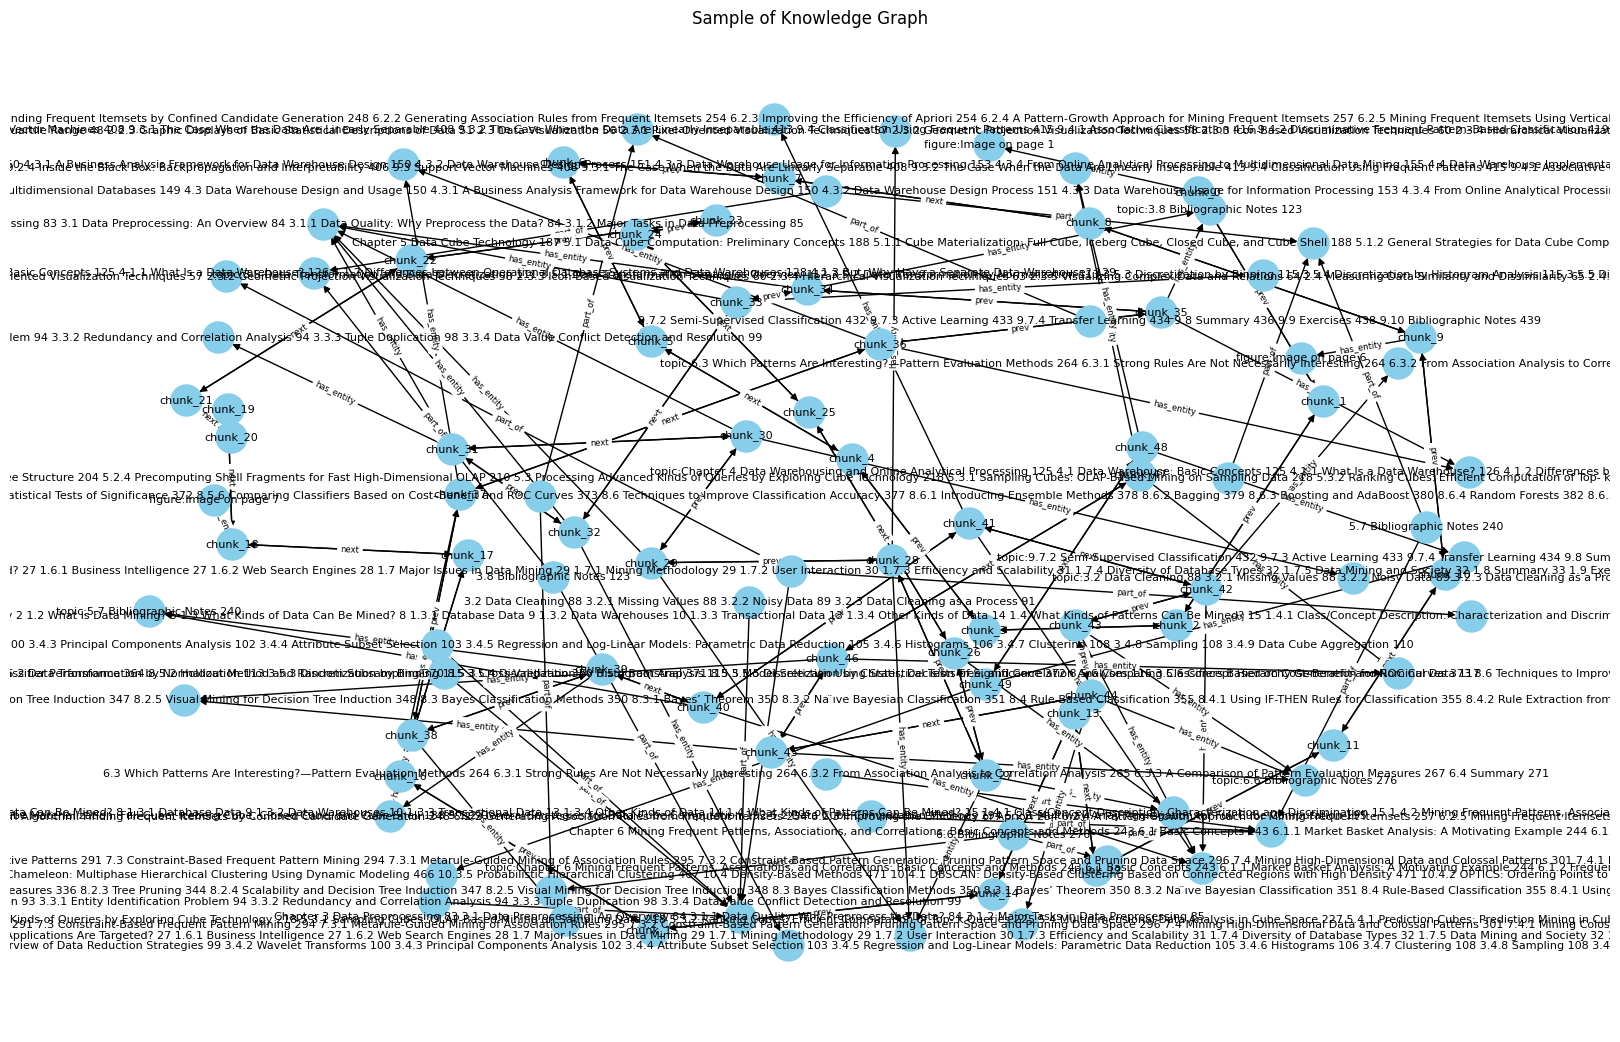

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 10))

# Optionally, visualize only a sample/subgraph for clarity
sub_nodes = list(G.nodes())[:100]  # For big graphs, e.g. first 100
SG = G.subgraph(sub_nodes)

pos = nx.spring_layout(SG, k=0.5)
nx.draw(SG, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=8, arrows=True)

# Optionally: Show edge labels (types)
edge_labels = nx.get_edge_attributes(SG, 'type')
nx.draw_networkx_edge_labels(SG, pos, edge_labels=edge_labels, font_size=6)
plt.title("Sample of Knowledge Graph")
plt.show()


In [9]:
# Example: find all entity nodes of type 'formula'
formulas = [n for n, d in G.nodes(data=True) if d.get('entity_type') == 'formula']
print("Formula nodes:", formulas)

# Example: Get neighbors of a specific chunk node
node = "chunk_10"
print("Neighbors:", list(G.neighbors(node)))


Formula nodes: ['formula:$40,000 to $', 'formula:$100 than with $', 'formula:$54,000. Suppose that we had only the first 11 values in the list. Given an odd number of values, the median is the middlemost value. This is the sixth value in this list, which has a value of $', 'formula:$10–20,000, $', 'formula:$52,000 and $', 'formula:$47,000 and Q 3 is $', 'formula:$16,000. (Note that the sixth value is a median, $', 'formula:$80, Q 1 is $', 'formula:$60, while 25% of items sold at branch 2 were less than or equal to $', 'formula:$78, while 50% of items at branch 2 were less than $', 'formula:$1 to $', 'formula:$224,000 $', 'formula:$350,000 $', 'formula:$1,568,000 $', 'formula:$600...$', 'formula:$800...$', 'formula:$400...$', 'formula:$200...$', 'formula:$0...$', 'formula:$ X ... $', 'formula:$ X (exclusive) to $', 'formula:$12,000 and $', 'formula:$54,000 and $', 'formula:$600 $', 'formula:$400 $', 'formula:$200 $', 'formula:$0 $', 'formula:$85,000 female 40 college programmer $', 'for

### Vector Database Indexing

In [10]:
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import pandas as pd
from sentence_transformers import SentenceTransformer
import numpy as np
import faiss

# Initialize models (make sure 'transformers' and 'sentence-transformers' are installed!)
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
text_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

def get_blip_caption(image_path):
    img = Image.open(image_path).convert('RGB')
    inputs = processor(img, return_tensors="pt")
    out = blip_model.generate(**inputs)
    caption = processor.decode(out[0], skip_special_tokens=True)
    return caption

def embed_text(text):
    return text_model.encode(text)

# Assuming chunks is your list of dicts as before:
df = pd.DataFrame(chunks)

# You should have local image paths for each image chunk!
# If using PyMuPDF, images are often extracted and saved—make sure to populate image paths in your chunks.
all_embeddings = []
image_captions = []

for idx, chunk in df.iterrows():
    if chunk['type'] in ['text', 'table']:
        embed = embed_text(chunk['content'])
        all_embeddings.append(embed)
        image_captions.append(None)
    elif chunk['type'] == 'image':
        image_path = chunk.get('image_path')  # Should have been set in your extraction step
        if not image_path:
            all_embeddings.append(np.zeros((text_model.get_sentence_embedding_dimension(),)))
            image_captions.append(None)
            continue
        caption = get_blip_caption(image_path)
        all_embeddings.append(embed_text(caption))  # Caption embedded for multimodal retrieval
        image_captions.append(caption)
    elif chunk['type'] == 'equation':
        eq_text = ' '.join(chunk.get('latex_equations', []))
        embed = embed_text(eq_text)
        all_embeddings.append(embed)
        image_captions.append(None)
    else:
        all_embeddings.append(np.zeros((text_model.get_sentence_embedding_dimension(),)))
        image_captions.append(None)

df['embedding'] = all_embeddings
df['blip_caption'] = image_captions

# Build FAISS vector index for semantic retrieval
emb_matrix = np.vstack(df['embedding'].to_list()).astype(np.float32)
faiss_index = faiss.IndexFlatL2(emb_matrix.shape[1])
faiss_index.add(emb_matrix)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


# Pre Retrival Enhancement
1. Wide-pool Semantic Retrieval:
Retrieve top-K (e.g., 40-100) chunks from your vector DB.Pre-filter by metadata (e.g., chunk type, section).

2. Filter by Intent/Metadata:
Further narrow to chunks with matching type—using a simple intent detector or keyword rules (example: for math question, prefer formula/table/image nodes).

3. Graph Expansion (KG context):
Expand each candidate's context using graph neighbors (prev/next chunk IDs, KG neighbor nodes).

4. *Rerank* *Deep*:
Use a cross-encoder to rerank candidates (query–chunk/context pair).

In [11]:
# import needed libraries
from sentence_transformers import CrossEncoder
import numpy as np

# 0. INPUT: query, faiss_index, df, knowledge graph G, crossencoder
query = "How is support calculated in Apriori? Show formula."
num_candidates = 60        # Wide pool size
rerank_final = 8           # Final top-N for LLM context

# 1. Pool wide from vector DB
def pool_wide(query, k=num_candidates):
    qvec = embed_text(query)
    D, I = faiss_index.search(np.array([qvec]), k)
    candidates = df.iloc[I[0]].reset_index(drop=True)
    return candidates

# 2. Filter/expand by intent & metadata (EX: prioritize formulas if math keyword)
def filter_for_intent(candidates, query):
    if any(word in query.lower() for word in ["formula", "equation", "math", "calculate", "$", "\\"]):
        formulas = candidates[candidates['latex_equations'].str.len() > 0]
        if len(formulas) > 0:
            return formulas
    return candidates

# 3. Graph-based context expansion
def expand_with_graph(candidates, G):
    # For each chunk, bring in its prev/next chunk and direct KG neighbors
    expanded_rows = []
    seen = set()
    for _, row in candidates.iterrows():
        main_id = f"chunk_{row['chunk_id']}"
        if main_id not in seen:
            expanded_rows.append(row)
            seen.add(main_id)
        # Add prev/next chunks if present
        for attr in ['prev_chunk_id', 'next_chunk_id']:
            if row[attr] is not None:
                neighbor_id = f"chunk_{row[attr]}"
                # Try to add neighbor from your df
                if neighbor_id in G and int(row[attr]) in df['chunk_id'].values:
                    neighbor_row = df[df['chunk_id'] == row[attr]].iloc[0]
                    if f"chunk_{neighbor_row['chunk_id']}" not in seen:
                        expanded_rows.append(neighbor_row)
                        seen.add(f"chunk_{neighbor_row['chunk_id']}")
        # Add all direct KG neighbors (entity nodes only)
        for neighbor in G.neighbors(main_id):
            chunk_id = G.nodes[neighbor].get('chunk_id')
            if chunk_id is not None and f"chunk_{chunk_id}" not in seen:
                if chunk_id in df['chunk_id'].values:
                    neighbor_row = df[df['chunk_id'] == chunk_id].iloc[0]
                    expanded_rows.append(neighbor_row)
                    seen.add(f"chunk_{chunk_id}")
    return pd.DataFrame(expanded_rows)

# 4. Deep re-rank with cross-encoder (can use 'content' OR merged context columns)
crossenc = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

def deep_rerank(query, candidates, col="content", n_final=rerank_final):
    pairs = [(query, str(t)) for t in candidates[col]]
    scores = crossenc.predict(pairs)
    candidates = candidates.copy()
    candidates['rerank_score'] = scores
    return candidates.sort_values("rerank_score", ascending=False).head(n_final)

# Workflow
candidates = pool_wide(query)
candidates = filter_for_intent(candidates, query)
candidates = expand_with_graph(candidates, G)
final_chunks = deep_rerank(query, candidates)

# Now use final_chunks for LLM context assembly/prompt/answer!


## Retriver + Prompt Engineering

In [12]:
from sentence_transformers import CrossEncoder
import pandas as pd

# ----------- RETRIEVAL PIPELINE -----------

def pool_wide(query, faiss_index, df, k=60):
    qvec = embed_text(query)
    D, I = faiss_index.search(np.array([qvec]), k)
    candidates = df.iloc[I[0]].reset_index(drop=True)
    return candidates

def filter_for_intent(candidates, query):
    # Example: focus on formulas/equations for math queries
    if any(word in query.lower() for word in ["formula", "equation", "math", "calculate", "$", "\\"]):
        formulas = candidates[candidates['latex_equations'].str.len() > 0]
        if len(formulas) > 0:
            return formulas
    return candidates

def expand_with_graph(candidates, G, df):
    # Expand each candidate with immediate prev/next and KG neighbors
    expanded_rows = []
    seen = set()
    for _, row in candidates.iterrows():
        main_id = f"chunk_{row['chunk_id']}"
        if main_id not in seen:
            expanded_rows.append(row)
            seen.add(main_id)
        for attr in ['prev_chunk_id', 'next_chunk_id']:
            if row[attr] is not None:
                neighbor_id = f"chunk_{row[attr]}"
                if neighbor_id in G and int(row[attr]) in df['chunk_id'].values:
                    neighbor_row = df[df['chunk_id'] == row[attr]].iloc[0]
                    if f"chunk_{neighbor_row['chunk_id']}" not in seen:
                        expanded_rows.append(neighbor_row)
                        seen.add(f"chunk_{neighbor_row['chunk_id']}")
        for neighbor in G.neighbors(main_id):
            chunk_id = G.nodes[neighbor].get('chunk_id')
            if chunk_id is not None and f"chunk_{chunk_id}" not in seen:
                if chunk_id in df['chunk_id'].values:
                    neighbor_row = df[df['chunk_id'] == chunk_id].iloc[0]
                    expanded_rows.append(neighbor_row)
                    seen.add(f"chunk_{chunk_id}")
    return pd.DataFrame(expanded_rows)

crossenc = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

def deep_rerank(query, candidates, col="content", n_final=8):
    # Rerank candidates with cross-encoder model
    pairs = [(query, str(t)) for t in candidates[col]]
    scores = crossenc.predict(pairs)
    candidates = candidates.copy()
    candidates['rerank_score'] = scores
    return candidates.sort_values("rerank_score", ascending=False).head(n_final)

# ----------- PROMPT ENGINEERING -----------

def build_rag_prompt(query, ranked_chunks):
    prompt = (
        "You are an expert assistant for the textbook 'Data Mining Concepts and Techniques'.\n"
        "ONLY use the provided context. Cite data, formulas, images, tables, and page/section when possible.\n"
        "----- CONTEXT START -----\n"
    )
    for i, row in ranked_chunks.iterrows():
        heading = row['hierarchy'].get('section', 'Unknown')
        page = row.get('page', 'N/A')
        if row['type'] == 'text':
            prompt += f"[Section: {heading}, Page: {page}] {row['content']}\n"
        elif row['type'] == 'image':
            caption = row.get('blip_caption', '[Figure]')
            prompt += f"[Figure, Page: {page}] {caption}\n"
        elif row['type'] == 'table':
            prompt += f"[Table, Page: {page}] {row['content']}\n"
        elif row['type'] == 'equation' or (row.get('latex_equations') and len(row['latex_equations']) > 0):
            for eq in row['latex_equations']:
                prompt += f"[Equation, Page: {page}] {eq}\n"
        else:
            prompt += f"[Other, Page: {page}] {str(row['content'])}\n"
    prompt += "----- CONTEXT END -----\n"
    prompt += (
        f"User question: {query}\n"
        "Instructions:\n"
        "- ONLY use the context above to answer, no outside info.\n"
        "- Return formulas as raw LaTeX, do not modify them.\n"
        "- If images/tables are relevant, reference their caption/page.\n"
        "- For ambiguous input, state what context is missing or summarize relevant context.\n"
        "- Give answers in clear academic style, citing sections/figures/tables/equations as needed.\n"
    )
    return prompt

# ----------- FULL PIPELINE EXAMPLE -----------

def full_advanced_rag_retrieval(query, faiss_index, df, G, n_pool=60, n_final=8):
    candidates = pool_wide(query, faiss_index, df, k=n_pool)
    candidates = filter_for_intent(candidates, query)
    candidates = expand_with_graph(candidates, G, df)
    final_chunks = deep_rerank(query, candidates)
    final_prompt = build_rag_prompt(query, final_chunks)
    return final_prompt, final_chunks

# Usage:
# final_prompt, final_chunks = full_advanced_rag_retrieval(query, faiss_index, df, G)
# print(final_prompt)

# Then run your LLM pipeline (Mistral, Qwen, Gemma, etc.) using final_prompt for SOTA answers!


In [13]:
final_prompt, final_chunks = full_advanced_rag_retrieval(query, faiss_index, df, G)
print(final_prompt)

You are an expert assistant for the textbook 'Data Mining Concepts and Techniques'.
ONLY use the provided context. Cite data, formulas, images, tables, and page/section when possible.
----- CONTEXT START -----
[Section: 7.3 Constraint-Based Frequent Pattern Mining 297, Page: 335] The first category of constraints is antimonotonic . Consider the rule constraint “ sum ( I . price ) ≤ $ 100” of Example 7.8. Suppose we are using the Apriori framework, which explores itemsets of size k at the k th iteration. If the price summation of the items in a candidate itemset is no less than $100, this itemset can be pruned from the search space, since adding more items into the set (assuming price is no less than zero) will only make it more expensive and thus will never satisfy the constraint. In other words, if an itemset does not satisfy this rule constraint, none of its supersets can satisfy the constraint. If a rule constraint obeys this property, it is antimonotonic . Pruning by antimonotonic 

## LLM Pipeline

In [14]:
pip install hf_xet

Note: you may need to restart the kernel to use updated packages.


In [16]:
!pip install google-generativeai

INFO: pip is looking at multiple versions of grpcio-status to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of grpcio-status to determine which version is compatible with other requirements. This could take a while.
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------------------------------- 1.3/1.3 MB 49.3 MB/s  0:00:00
   ---------------------------------------- 0.0/4.7 MB ? eta -:--:--
   ---------------------------------------- 4.7/4.7 MB 42.7 MB/s  0:00:00
   ---------------------------------------- 0.0/14.5 MB ? eta -:--:--
   ---------------- ----------------------- 6.0/14.5 MB 29.7 MB/s eta 0:00:01
   ------------------------------ --------- 11.0/14.5 MB 26.6 MB/s eta 0:00:01
   ---------------------------------------- 14.5/14.5 MB 24.9 MB/s  0:00:00
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ---------------------------------

In [19]:
from transformers import pipeline

# Pick one:
model_name = "google/flan-t5-base"
# or
# model_name = "microsoft/DialoGPT-medium"

# Create the generation pipeline
llm_pipe = pipeline(
    "text2text-generation" if "flan-t5" in model_name else "text-generation",
    model=model_name,
    device=-1  # Use CPU for compatibility
)

# Get response from your prompt (replace final_prompt with your variable)
output = llm_pipe(final_prompt)[0]['generated_text' if 'generated_text' in llm_pipe.model.config.__dict__ else 'generated_text']
print(output)


Device set to use cpu
Token indices sequence length is longer than the specified maximum sequence length for this model (1874 > 512). Running this sequence through the model will result in indexing errors


Return formulas as raw LaTeX, do not modify them. ----- [Section: 7.3 Constraint-Based Frequent Pattern Mining 297, Page: 335] The first category of constraints is antimonotonic. Consider the rule constraint “ sum ( I . price )  $ 100” of Example 7.8. Suppose we are using the Apriori framework, which explores itemsets of size k at the k th iteration. If the price summation of the items in a candidate itemset is no less than $100, this itemset can be pruned from the search space, since adding more items into the set (assuming price is no less than zero) will only make it more expensive and thus will never satisfy the constraint. If a given itemset does not satisfy this constraint, none of its supersets can satisfy the constraint. If a rule constraint in Example 7.8 were “ sum ( I . price )  $ 100,” the constraint-based processing method would be quite different. If a rule constraint is succinct, we can directly generate precisely the


In [ ]:
# answer based on the user question
# Loop for user-driven QA
while True:
    user_query = input("You: ")
    if user_query.strip().lower() in {"exit", "quit"}:
        print("Chatbot session ended.")
        break

    # MAIN RAG PIPELINE CALL
    # full_advanced_rag_retrieval returns prompt based on user_query
    final_prompt, _ = full_advanced_rag_retrieval(user_query, faiss_index, df, G)

    # LLM Generation
    output = llm_pipe(final_prompt)[0]
    response = output.get('generated_text', output.get('text', "[No answer available]"))
    print("\nBot:", response)
    print("-" * 60)



Bot: Give answers in clear academic style, citing sections/figures/tables/equations as needed. -----
------------------------------------------------------------

Bot: Give answers in clear academic style, citing sections/figures/tables/equations as needed. -----
------------------------------------------------------------
